# Introduction 

NOTE: THIS NOTEBOOK IS A WORK IN PROGRESS

This notebook provides a walkthrough some of the calssic time series modelling paradigms, explaining concepts such as Auto-Correlation and Auto-Regression, ARIMA Models, and evaluating forecasts. I am using material inspired by [this](https://www.youtube.com/watch?v=_9lBwXnbOd8&feature=youtu.be&ab_channel=YuryKashnitsky) lecture and the following references. 

References

[Forecasting: Principles and Practice](https://otexts.com/fpp2)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# use this if you want to render static plotly images to display them on Github
# otherwise, comment this section out to enjoy interactive plotly plots
import plotly.io as pio
pio.renderers.default = "svg"

from ts import data
from ts import viz

viz.set_mpl_style();

# Data

I will use multiple datasets through this notebook, depending on what we want to do or show

## Monthly Gloabl Temp

Global Temperature Time Series. Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG). Two datasets are provided: 1) global monthly mean and 2) annual mean temperature anomalies in degrees Celsius from 1880 to the present. **This dataset is a good example to show seasonality (temp cycle over the year) & trend (global warming)**

In [3]:
temp = data.load_globaltemp(frmt='pandas', mode='monthly')
temp = temp.groupby('Date').mean().rename(columns={'Mean': 'temp'})
temp.head(2)

,temp
Date,
1880-01,-0.14955
1880-02,-0.16645


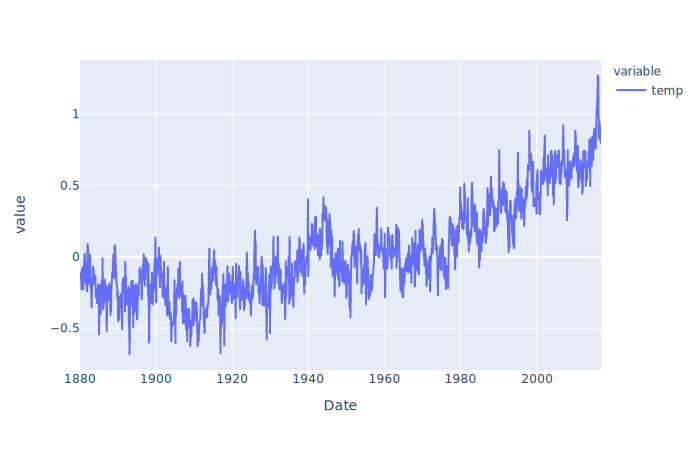

In [4]:
# we plot this quickly using plotly express library
px.line(temp, y=['temp'])

## Sunspots
Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle. **This dataset is a good example of seasonality in time series**

Source: https://en.wikipedia.org/wiki/Sunspot

In [5]:
sunspots = data.load_sunspots(frmt='pandas')

# parse dates and rename columns to something more convenient
sunspots['Date'] = pd.to_datetime(sunspots['Date'], format='%Y-%m-%d')
sunspots = sunspots.rename(columns={'Monthly Mean Total Sunspot Number': 'number'})
sunspots.head(5)

,Date,number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


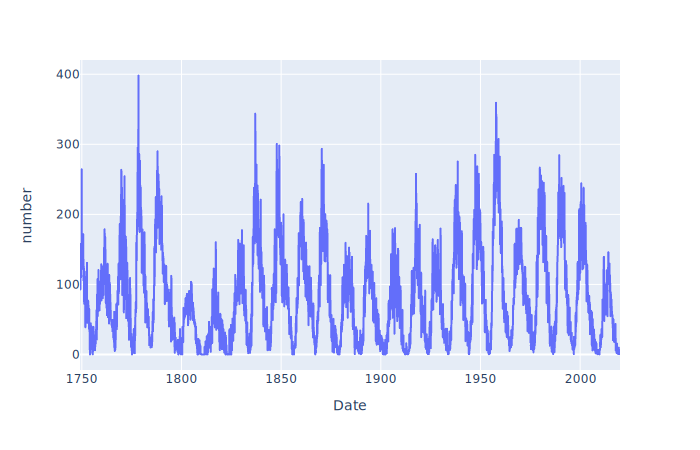

In [6]:
px.line(sunspots, x='Date', y='number')

## Weekly Sales

The data we are going to use is a weekly sales and price data for 9 stores and 3 products. I found this on a Medium Blog post by Susan Li. This dataset is a good example of how anomalies, like holidays show up in a time series.

Source: https://towardsdatascience.com/sales-forecasting-with-price-promotion-effects-b5d70207b128

In [7]:
sales_data = data.load_store_sales()
sales_data.head(2)

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453


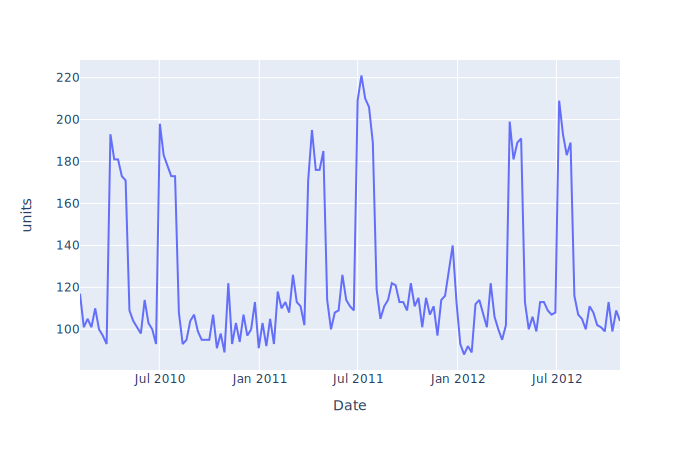

In [8]:
# we'll trim this down a bit, we'll just focus on one product and keep the date and units sold column
sales = (sales_data
         .query('Product == 2 and Store == 3 ')
         .filter(['Date', 'Weekly_Units_Sold'])
         .rename(columns={'Weekly_Units_Sold': 'units'})
        )

if sales['Date'].dtype == np.object:
    sales['Date'] = pd.to_datetime(sales['Date'], format="%m/%d/%Y").dt.date
    
px.line(sales, x='Date', y='units')

## White noise

Just in case, here is a white noise dataset.

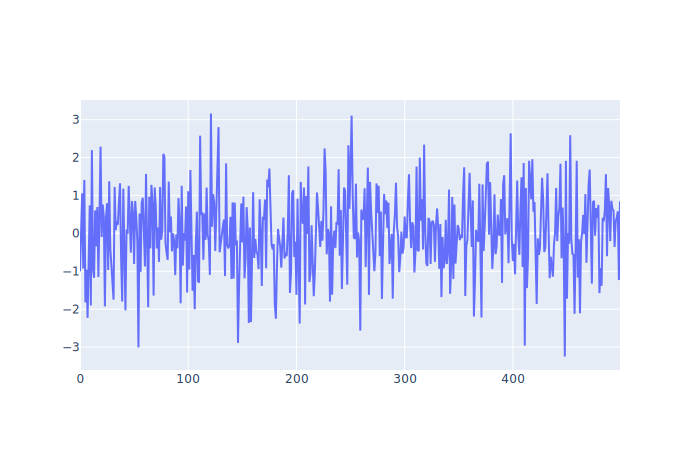

In [9]:
noise = np.random.normal(0, 1, 500)

viz.plot_basic_timeseries(noise)

# Time Series Decomposition (Trend, Seasonality, Cycles, Noise)

Wold's decomposition or the Wold representation theorem (not to be confused with the Wold theorem that is the discrete-time analog of the Wiener–Khinchin theorem), named after Herman Wold, says that every covariance-stationary time series $ Y_{t}$ can be written as the sum of two time series, one deterministic and one stochastic

Source: Wikipedia

This provides theoritical basis for time series decomposition. The idea is to develop a model that captures the deterministic component and learn the distribution of the noise so it can come up with a good foreacast for the time series. 

## The idea of auto-correlation

Auto means self. Auto-correlation is the correlation of a time series with its lagged self. If there is a trend in the series, then we should expect a point to be close to its previous and next neighbours. Therefore, you should see a correlation between a time series and its lagged self. Try this on white noise, and you get nothing

In [10]:
# You can compute auto-corr directly in pandas like this
temp['temp'].autocorr(lag=1)

0.9467067662403763

Correlation is reported on a scale of -1 to 1 (it's a normalized covariance). Here we see that monthly mean temperature time series has a strong auto-correlation with its 1 month lagged self. Makes sense, mean temperature is usually close to the mean temperature of previous month. We can play around with the lag and see how it the auto-corr changes

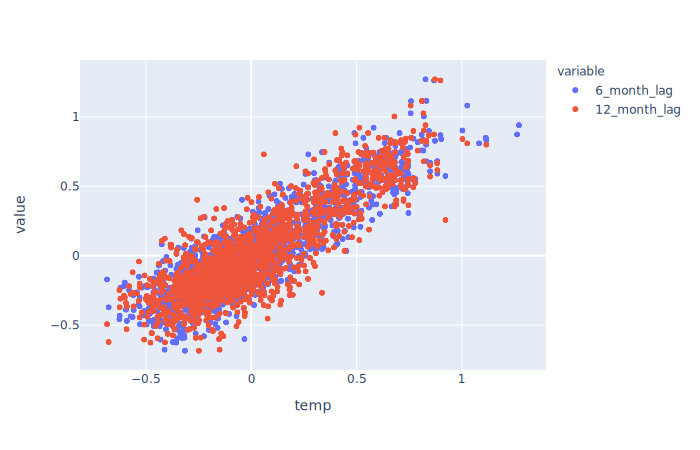

In [11]:
temp['6_month_lag'] = temp['temp'].shift(-6)
temp['12_month_lag'] = temp['temp'].shift(-12)

px.scatter(temp, x='temp', y=['6_month_lag', '12_month_lag'])

Now let's try on the whitenoise

In [12]:
df = pd.DataFrame(data=[])
df['noise'] = noise
df['lag_1'] = df['noise'].shift(1)
df['noise'].autocorr(1)

-0.049523988649684436

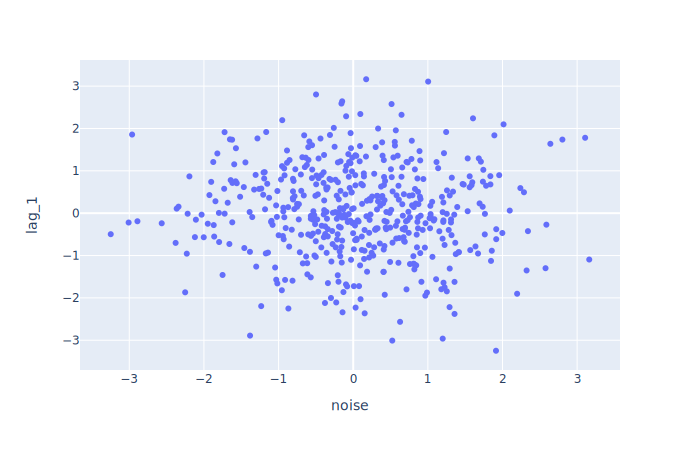

In [13]:
px.scatter(df, x='noise', y='lag_1')

as expected, no information whatsoever

## Auto Correlation Function (ACF)

The Auto Correlation Function (ACF), also known as the Correlogram, is a plot that shows different lag values and the corresponding correlation, for a given time series. statistical packages usually come with a function to plot acf. Here we will use the function provided by `statsmodels` under the `graphics` package

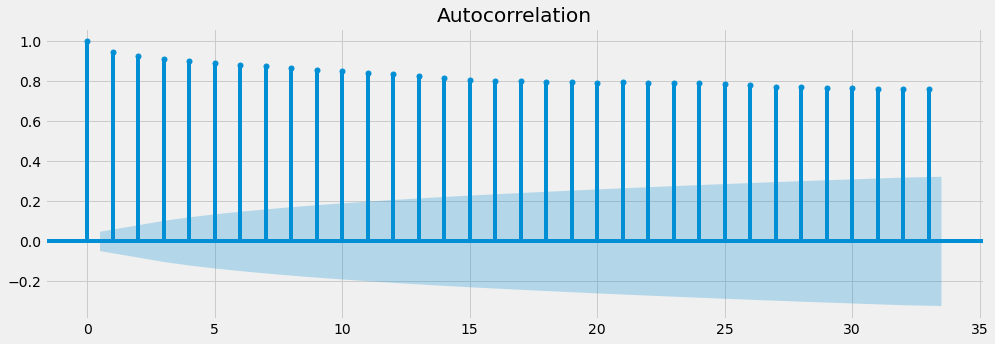

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(temp['temp']);

The auto-correlation persists even at 30+ lags. ACF usually show the level of significance of the correlation to indicate whether there is statistically signficant correlations (that's the blue band surrounding the x-axis)

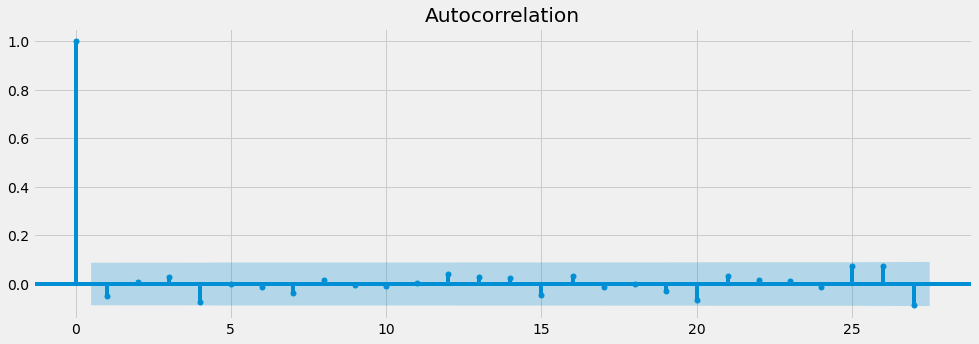

In [15]:
plot_acf(noise);

as you can see above, the ACF shows all spikes below the blue band, indicating non of these are statistically significant

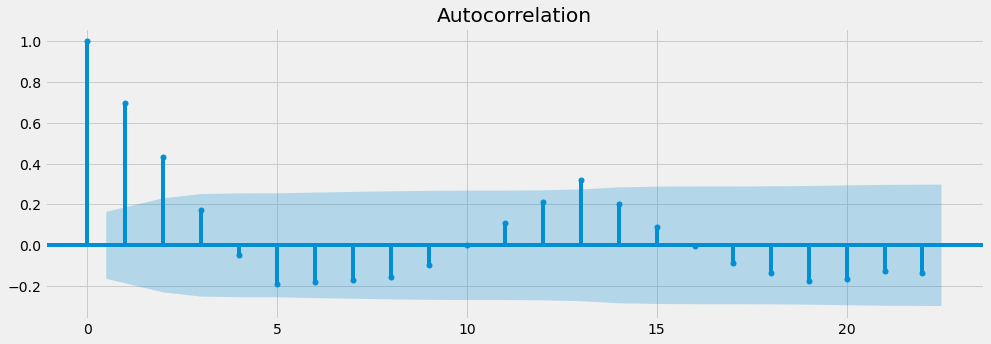

In [16]:
plot_acf(sales['units']);

The weekly sales dataset shows that the series correlates with itself with lag 1 and 2 weeks. There is also a barely significant spike around the 12th week, which might suggest something about a 12 weeks (three months) seasonality. It's not very strong though, but the 12 weeks number is interesting. What could it be? Maybe they give out promotions every quarter or something like that

## Partial Auto Correlation Function (PACF)

PACF is best explained using this excerpt from "Forecasting Principles and Practice" Book


Recall that an ACF plot shows the autocorrelations which measure the relationship between $y_t$ and $y_{t-k}$ for different values of k.Now if $y_t$ and $y_{t-1}$ are correlated, then $y_{t-1}$ and $y_{t-2}$ must also be correlated. However, then $y_t$ and $y_{t-2}$ might be correlated, simply because they are both connected to $y_{t-1}$ rather than because of any new information contained in $y_{t-2}$ that could be used in forecasting $y_{t}$

To overcome this problem, we can use partial autocorrelations. These measure the relationship between $y_t$ and $y_{t-k}$ after removing the effects of lags 1, 2, 3, ..., k-1. So the first partial autocorrelation is identical to the first autocorrelation, because there is nothing between them to remove. Each partial autocorrelation can be estimated as the last coefficient in an autoregressive model


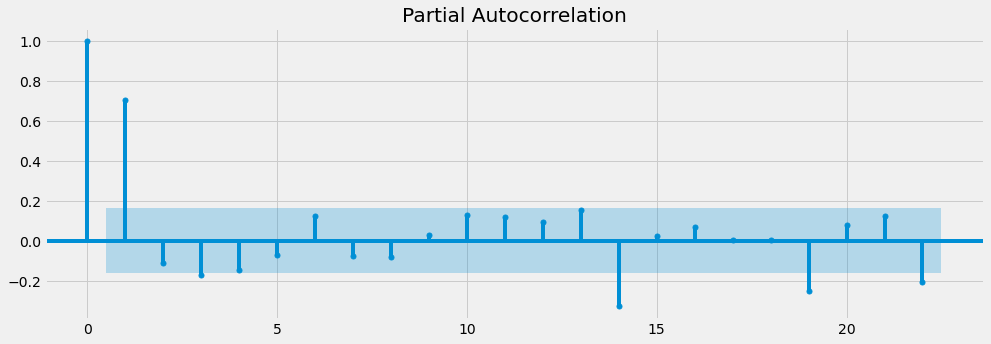

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(sales['units']);

this is much better, doesn't give us false impressions about auto-corr beyond the second or maybe third lag.

## Seasonal and Trend decomposition using Loess (STL) Decomposition

A time series can be expressed as an additive model with three components

1. Trend
2. Seasonality
3. Noise (or residue)

The STL decomposition is a technique that uses LOESS Regression to compute these components. Once you decompose a time series into these components, and you believe the decomposition makes sense, then you can examine the residues for anomalies (for example, find residues that are 3 stddev from the mean)

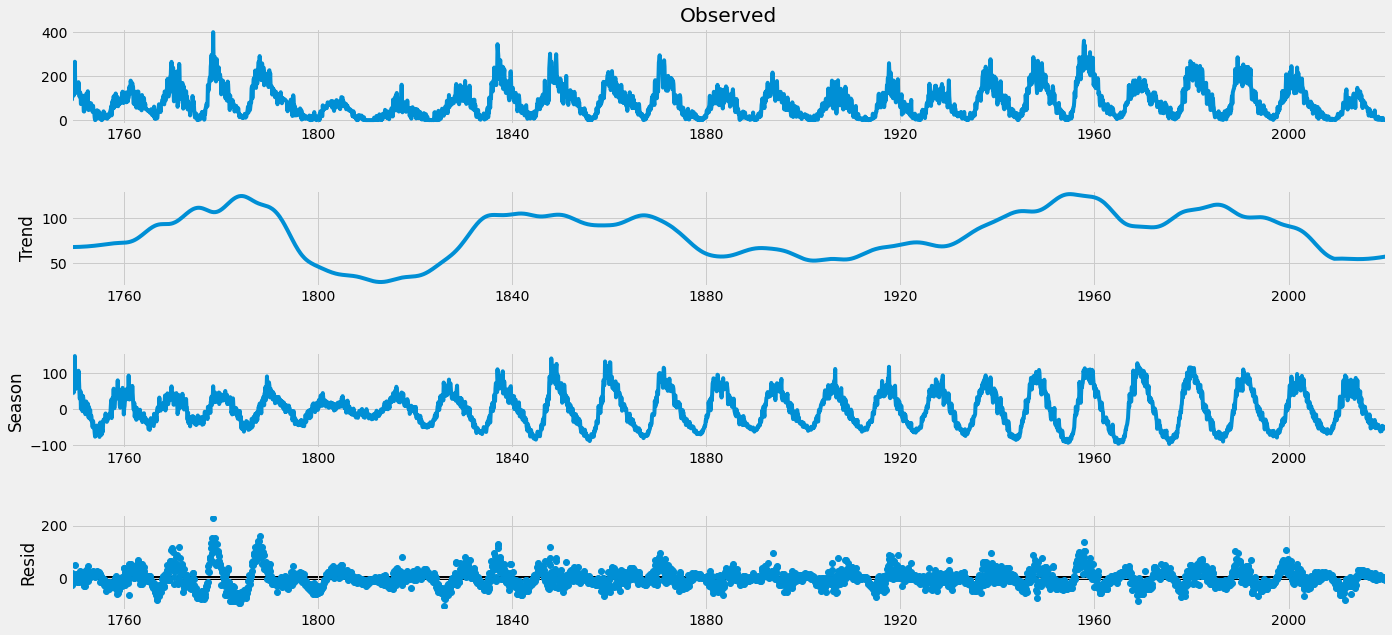

In [18]:
from statsmodels.tsa.seasonal import STL


stl = STL(sunspots.set_index('Date'), period=11*12+1) # 11 years cycle, so 11*12 months 
result = stl.fit()
fig = result.plot()

plt.gcf().set_size_inches(20, 10)

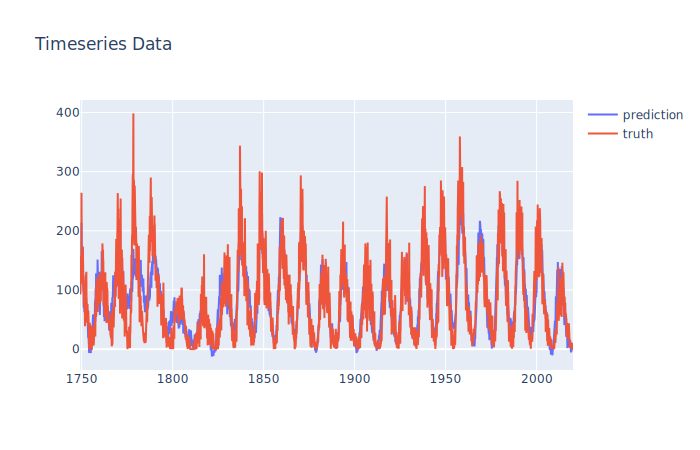

In [19]:
# to actually get the three components
trend, seasonal, resid = result.trend, result.seasonal, result.resid

# then you can add the trend and seasonal components to make a prediction
prediction = trend + seasonal
viz.plot_basic_timeseries(
    [prediction, sunspots.number], 
    index=sunspots.Date, 
    names=['prediction', 'truth']
)

Not bad! Looks like we can make pretty good descriptions (we'll discuss how to quanitfy the error in a couple of sections) with such a simple model. Notice that there is a period in the time series where the prediction is a bit off (mostly overestimating the truth). These could be anomalies.

Let's plot these outliers

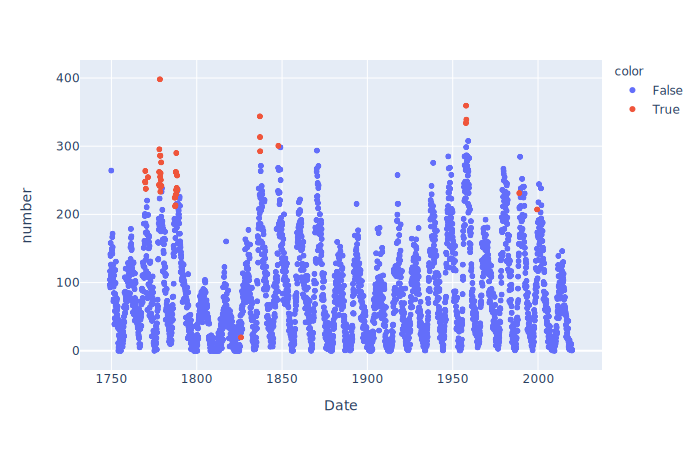

In [20]:
res_mean = resid.mean()
res_std = resid.std()

# outlier condition
nb_std = 3
outlier_cond = lambda x: (x >= res_mean + nb_std*res_std) or (x <= res_mean - nb_std*res_std)
outlier_mask = resid.apply(outlier_cond)

px.scatter(sunspots, x='Date', y='number', color=outlier_mask)

# Stationarity

from "Forecasting Principles and Practice" Book

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time

## Stationarizing a time series

## De-trending (getting a zero mean)

- Taking the derivative (differencing is the discrete equivalent of differentiating) and can be applied multiple times
- Seasonal Differencing $ \hat{y_t} = y_t - y_{t+s} $

Note that if we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1 [see Yury Kashnitsky's kaggle notebook](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

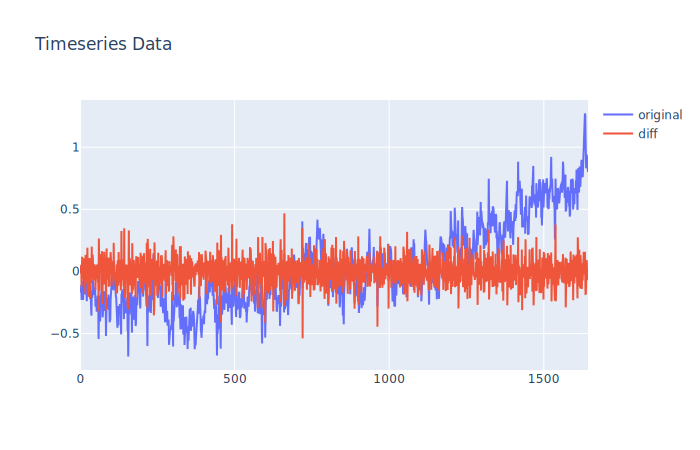

In [21]:
# simply taking the diff of the global temperature data removes the trend
viz.plot_basic_timeseries([temp.temp, temp.temp.diff()], names=['original', 'diff'])

### Applying a Variance Stabilizing Transformation
The property of constant variance is known as homoscedasticity. If a time series is not homoscedastic then its variance depends on time. We can stabilize the variance using one of the following transformations

- Log transformation
- Box-Cox transformation (parameterized)


After making the forecast, we need to apply an inverse transform to go back to the original scale. I will create a synthetic dataset just to show this effect.

In [22]:
from scipy import stats

first_part = np.random.normal(10, 1, 100)
second_part = np.random.normal(10, 2, 100)
non_stationary_series = np.concatenate([first_part, second_part])
log_transformed = np.log(non_stationary_series)
box_cox_transformed = stats.boxcox(non_stationary_series)[0]

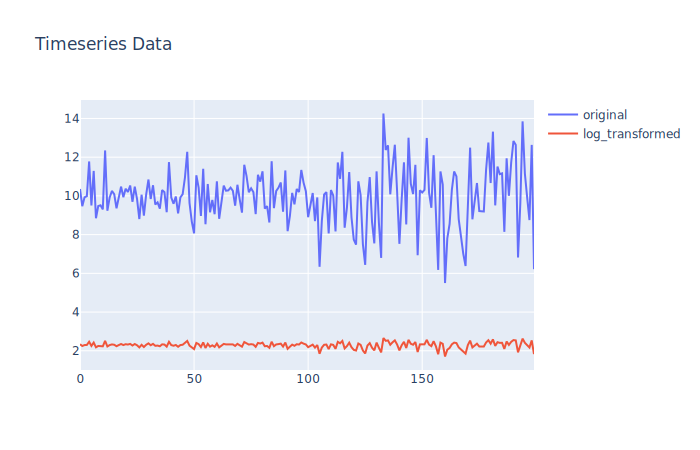

In [23]:
viz.plot_basic_timeseries([non_stationary_series, log_transformed], names=['original', 'log_transformed'])

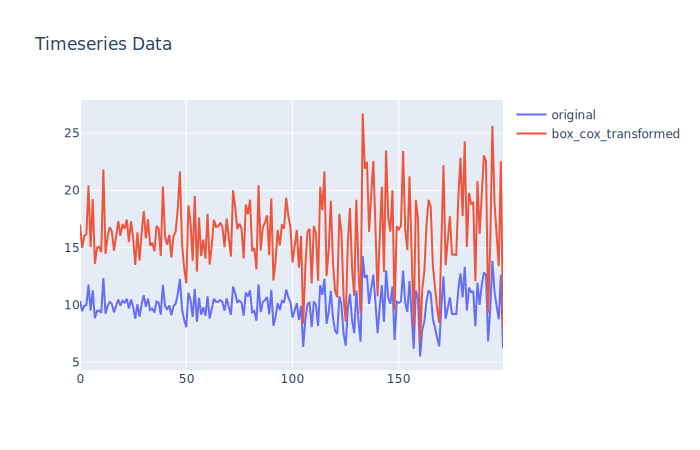

In [24]:
viz.plot_basic_timeseries([non_stationary_series, box_cox_transformed], names=['original', 'box_cox_transformed'])

# Evaluating forecasts

Clearly, we need a quantative measure of how well a model is forecasting a time series. Simple visual inspection is tedious and unscalable. It can also be misleading. The most obvious choice is using the Root Mean Squared Error (RMSE) to judge the forecast.


## Residuals Diagnostics
residuals in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values

Residuals must have these two properties:

- unbiasedness (mean zero) --> Wilcoxon Test
- uncorrelatdness (no auto-correlation)  --> Correlogram or Ljung-Box

The following two properties are nice to have but not necessary

- Normality --> qqplot or shapiro wilk test
- Stationary or constant variance  --> Visually or KPSS Test or Dickey-Fuller

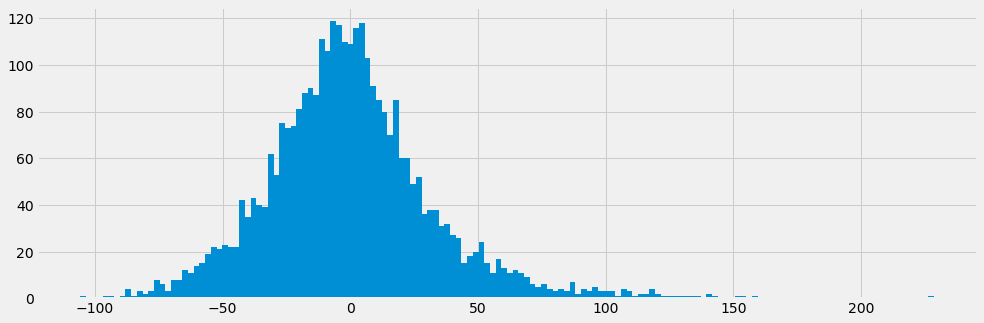

In [25]:
# we'll use the residuals from our simple sunspot mode
resid.hist(bins=150);

just from visual inspection, the residuals look normal. However, we want to ensure there is no bias in the distribution (i.e. the mean is zero). We test our hypothesis with the Wilcoxon Test

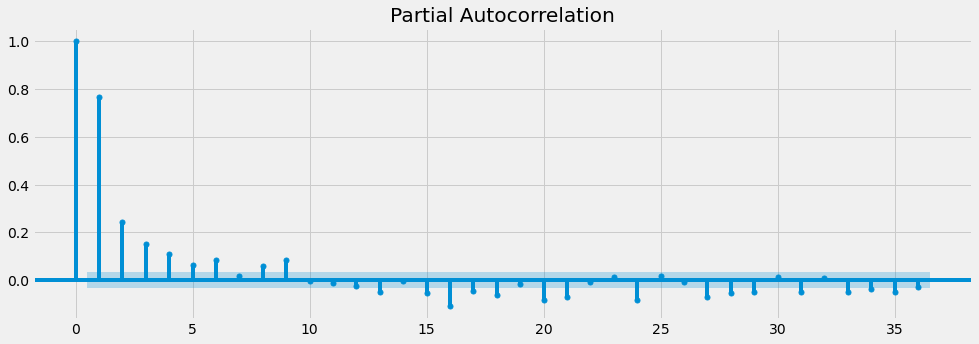

In [26]:
plot_pacf(resid);

the pacf shows clear auto-correlation of lags 1, 2 and maybe more for the residuals of the sunspots. It means out forecast did not capture all information and can be improved

25.064982661679593

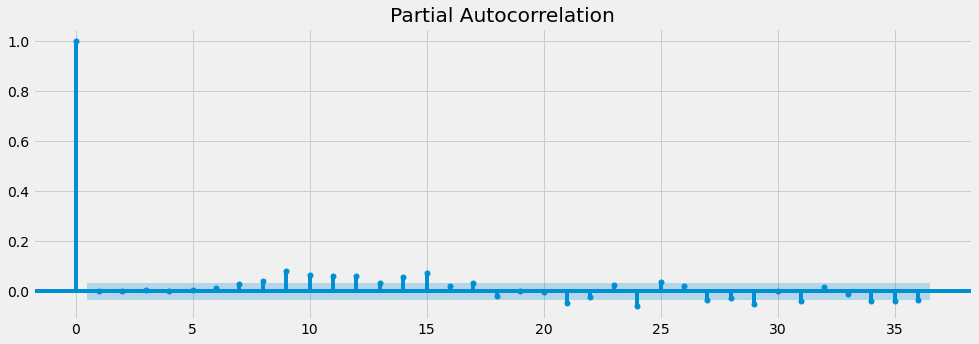

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def prep_data():
    # create features from lagged sunspot numbers
    sunspot_train = sunspots.copy()
    for lag in range(1, 10):
        sunspot_train[f'lag_{lag}'] = sunspot_train['number'].shift(lag)
    
    # our target is the number of sunspots
    sunspot_train = sunspot_train.rename(columns={'number': 'target'})
    sunspot_train = sunspot_train.dropna()

    # create the train dataset
    cols = [col for col in sunspot_train.columns if 'lag' in col]
    X_train = sunspot_train[cols]
    y_train = sunspot_train['target']
    
    return X_train, y_train
    

def train_and_predict(X_train, y_train):
    # train LR model
    lr = LinearRegression()
    lr.fit(X=X_train, y=y_train)

    # predict model (we're predicting on the train data on purpose, to overfit and get strong predictions)
    y_pred = lr.predict(X_train)
    
    return lr, y_pred


# run pipeline
X_train, y_train = prep_data()
model, y_pred = train_and_predict(X_train, y_train)

# compute residue
ml_residue = y_train - y_pred

plot_pacf(ml_residue);
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
rmse

In [30]:
# check the model coefficients to understand how the model is making predictions
model.coef_

array([ 0.57615614,  0.11205011,  0.09182262,  0.09531362,  0.0295316 ,
        0.05357119, -0.0272373 , -0.00215434,  0.03607273])

if we look at the linear regression coefficients, the model is using the past value (lag1) with a weight of 0.57 to make its prediction, then smaller combinations of the other lagged features

# ARIMA Models

ARIMA Models are a class of classical time series models that relies on the ideas of auto-regression and moving average to model trends and seasonality in any time series. They are widely succeful and for the most part, remain the state of the art in modelling and forecasting univariate time series with sparse data.

## AutoRegression

## Moving Average

## ARMA  - ARIMA - SARIMA

# Fitting ARIMA Models

## Akaike Information Criterion (AIC)

a substitute for cross validation. Balances between number of parameters (model complexity) and performance (i.e. regularizer)

Can we consider AIC as a form of regularization?
```
It can indeed be interpreted as a type of regularization, but it is not similar to lasso or ridge regression. The latter two regularize by penalizing nonzero values of the parameter estimates as part of the estimation procedure, whereas AIC, in effect, penalizes the number of parameters included in the model - which is typically specified by the modeler, not internally to the estimation procedure (with exceptions for certain automated model selection procedures such as stepwise regression.)

AIC is intended to facilitate comparisons between models, and the coefficient of 2 multiplying the 𝑘 is derived from asymptotic considerations. I agree the additive "4" is not useful and can be removed. However, given the derivation, it's clear that the factor of "2" should remain - it makes the penalty for adding parameters to the model twice as large as otherwise, so it really isn't the same as a penalty of just 𝑘, and does have some asymptotic optimality properties.
```

Source:

- jbowman (https://stats.stackexchange.com/users/7555/jbowman), Does Akaike's Information Criterion correspond to a type of regularization?, URL (version: 2017-12-15): https://stats.stackexchange.com/q/319054



## ARIMA Hyper-parameter Tuning

# ARIMA Forecasting Framework 

1. Plot the time series and observe patterns, seasonality, etc.
2. Transform the time series to stabilize the variance if needed
3. Decide on the order of differencing (d) and seasonal differencing (D)
4. Plot the ACF/PACF of the time series and use these plots to guess initial values for Hyper-parameters p,q,P,Q
5. Fit the models and compare their AIC Values, then select the winning combination of hyper-parameters
6. Check residuals to make sure our model is not missing any information

# Anomalies (e.g. Holidays) and SARIMAX

# Limitations and Practicality

Classical time series models such as ARIMA, SARIMA, etc. are theoritically well founded and therefore tend to perform well on univariate time series forecasting problems. However, due to the difficulties of estimating hyper-parameters, and the fact that we have to manually perform visual inspection of ACF/PACF, and check residuals, etc. they can be cumbersome if we have a large volume of data.

Modern Machine Learning approaches, those that depend on transforming time series forecasting problems to supervised learning problems, lend themselves better to multivariate time series problems, and univariate time series problems with large amount of data (>100 points).